In [57]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(style="white", color_codes=True)
from pandas import ExcelWriter
%matplotlib inline
from sklearn.utils import resample
from tqdm import tqdm_notebook
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import math
from datetime import datetime
import pymysql
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;
import time
import pickle


from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import chi2
import statsmodels.api as sm

In [58]:
import IDF
from AS import *

In [59]:
import psi
import AS

In [60]:
%run Binning.ipynb

In [61]:
df = pd.read_csv('csv/Sample_solva_27.04.2021_3.csv')

In [62]:
df = df[df['flag_in_mm']==1]

In [63]:
df['date_requested'] = pd.to_datetime(df['date_requested'])

df['yyyymm'] = df.apply(lambda row: 100*(row['date_requested'].year) + row['date_requested'].month, axis=1)
df['is_out'] = ( (df['date_requested']>='2020-12-15') & (df['date_requested']<='2021-01-19') ) 

In [64]:
df = df[df['date_requested'] <= '2021-01-19']

In [65]:
df.shape

(3072, 319)

In [66]:
vars_current = ['credit_id', 'flag_in_mm', 'date_requested',
                'target',
                'max_expired_days',
               'open_date_cnt_360d',
               'sum_IL_credit_sum_no_Crd',
               'IL_no_deep_delinq_no_Crd',
               'curr_adue_days',
               'exp_days_last',
               'main_score',
               'dependants_count',
               'coll_days_max_older',
              # 'employment',
               'bor_age']

In [67]:
df = df[vars_current]

In [68]:
df[df['target']==1].shape[0]/df.shape[0]

0.032552083333333336

In [69]:
df_req = df[['credit_id', 'date_requested']]

# Define parameters

In [70]:
# Target variable
df['y'] = df['target']
#df_out['y'] = df_out['target']
# put columns that need to be dropped
 

# Information value cut off
iv_co = 0.05


# Correlation cut off
cr_co = 0.8

# Max number of categorical bins
max_cat_bins = 4

# Min number of records to consider as `ELSE` group
min_num = 300

# Numerical bins (do not change if not really needed)
max_bin = 5
force_bin = 3 

In [71]:
y = df.y

In [72]:
#Filling separate variables
# No need

In [73]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

'''
Replacing rare values to avoid overfitting
Change `num_min` to vary the minimum number of categorical observations to be considered as `_ELSE_` group
Also can uncomment and change `perc_min`
'''

#df, else_df = replace_not_frequent(df, cat_vars, perc_min=0.5)
df, else_df = replace_not_frequent_2(df, cat_vars, num_min = min_num)

# Drop columns with only 1 value
df = drop_single_value_column(df)

In [74]:
df.head()

,credit_id,date_requested,target,max_expired_days,open_date_cnt_360d,sum_IL_credit_sum_no_Crd,IL_no_deep_delinq_no_Crd,curr_adue_days,exp_days_last,main_score,dependants_count,coll_days_max_older,bor_age,y
4,2181589,2020-07-08 12:46:54,0,0,1.0,109400.0,49.0,NaN,0.0,NaN,0,NaN,59,0
7,2183802,2020-07-09 18:31:18,0,0,1.0,NaN,49.0,NaN,0.0,12.0,1,1.0,35,0
10,2183709,2020-07-09 17:29:35,0,1,4.0,300000.0,49.0,-7.0,0.0,NaN,2,NaN,40,0
12,2175895,2020-07-03 07:25:22,0,0,2.0,NaN,49.0,-6.0,0.0,NaN,1,NaN,30,0
13,2175943,2020-07-03 10:04:37,0,0,4.0,500000.0,49.0,NaN,0.0,20.0,0,NaN,55,0


In [75]:
df_out = df[df['date_requested']>='2020-12-15']
df = df[df['date_requested']<'2020-12-15']
df.drop(['date_requested'], axis=1, inplace=True)

In [76]:
df_train, df_test, y_train, y_test = train_test_split(df, df.y, test_size=0.33, stratify=df.y, random_state=4)

In [77]:
(df_train.shape, df_test.shape, df_out.shape)

((1708, 13), (842, 13), (522, 14))

In [78]:
(df_train[df_train['target']==1].shape[0], df_train[df_train['target']==0].shape[0])

(58, 1650)

In [79]:
(df_test[df_test['target']==1].shape[0], df_test[df_test['target']==0].shape[0])

(29, 813)

In [80]:
(df_out[df_out['target']==1].shape[0], df_out[df_out['target']==0].shape[0])

(13, 509)

In [81]:
y_out = df_out.y

In [82]:
(df_train.shape, df_test.shape, df_out.shape)

((1708, 13), (842, 13), (522, 14))

In [83]:
#iv_df, IV = data_vars(df_train, df_train.y)

In [84]:
df_train.drop('y', axis=1, inplace=True)
df_test.drop('y', axis=1, inplace=True)
df_out.drop('y', axis=1, inplace=True)

In [85]:
(df_test.shape, df_out.shape)

((842, 12), (522, 13))

In [86]:
iv_df = pd.read_excel('variables_bins_.xlsx')
IV = pd.read_excel('IV_42.xlsx')

In [87]:
X_train, y_train = transform_df_to_woe(df_train, y_train, IV, iv_df, iv_cut_off=0.04)

Features left after IV drop: 9


In [88]:
X_test, y_test = transform_df_to_woe(df_test, y_test, IV, iv_df, iv_cut_off=0.04)

Features left after IV drop: 9


In [89]:
X_out, y_out = transform_df_to_woe(df_out, y_out, IV, iv_df, iv_cut_off=0.04)

Features left after IV drop: 9


In [90]:
X_train.shape

(1708, 9)

In [91]:
data =        [ 'max_expired_days',
            #   'open_date_cnt_360d',
               'sum_IL_credit_sum_no_Crd',
               'IL_no_deep_delinq_no_Crd',
               'curr_adue_days',
               'exp_days_last',
               'main_score',
               'dependants_count',
               'coll_days_max_older',
               'bor_age']
data_x = pd.concat([X_train, X_test, X_out])
data_y = pd.concat([y_train, y_test, y_out])

In [92]:
X_train_cpy1 = X_train.copy()
X_test_cpy1 = X_test.copy()
X_out_cpy1 = X_out.copy()

In [93]:
X_train = X_train_cpy1.copy()
X_test = X_test_cpy1.copy()
X_out = X_out_cpy1.copy()

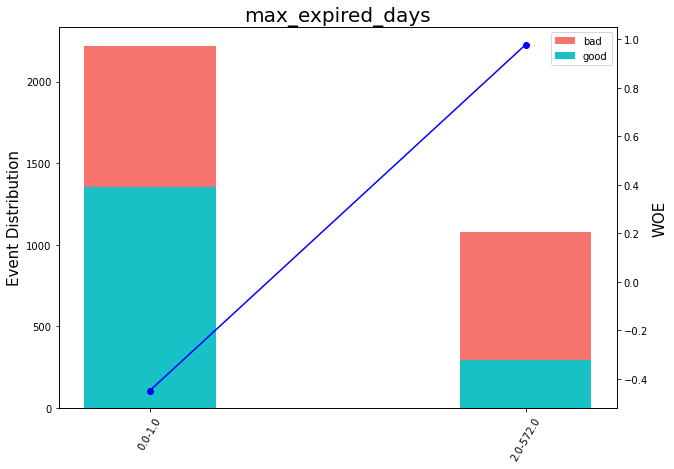

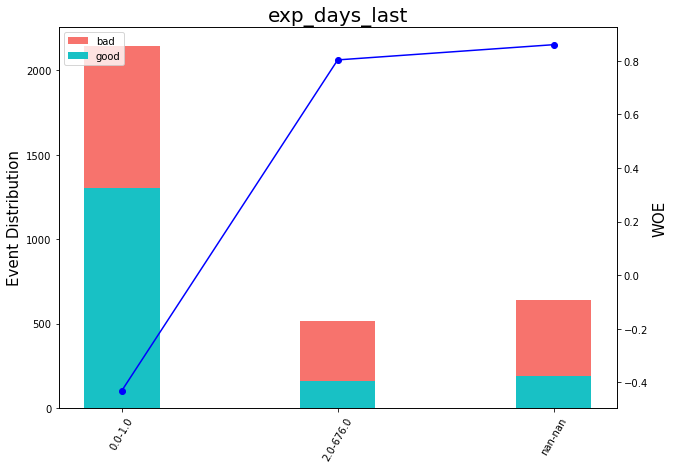

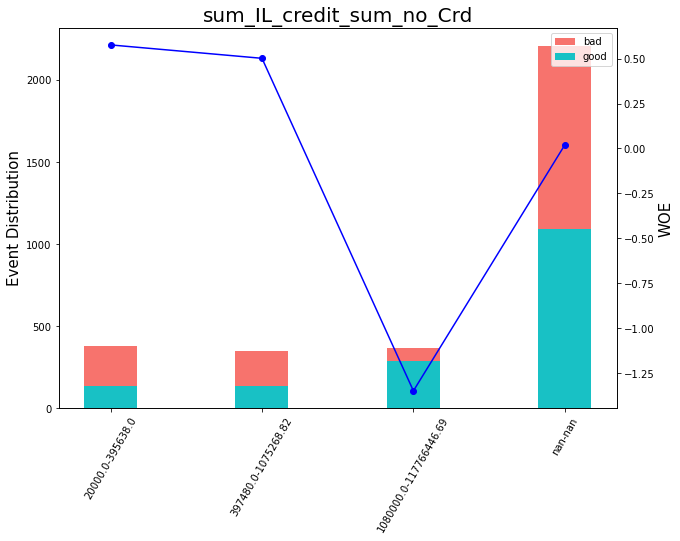

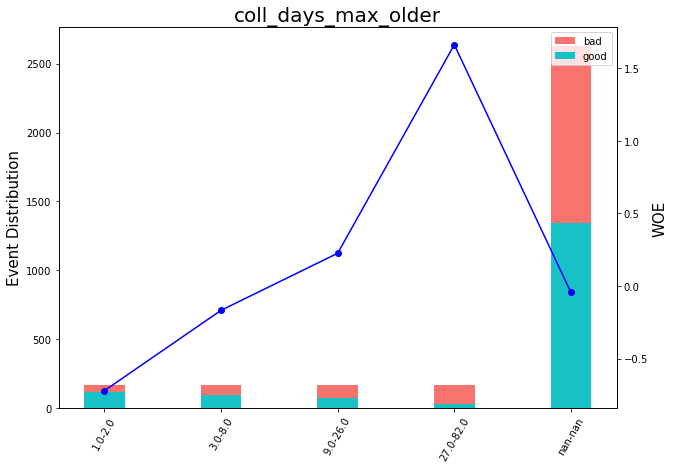

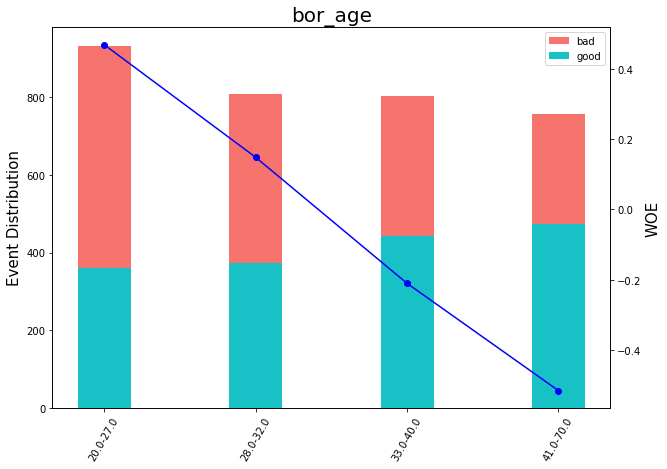

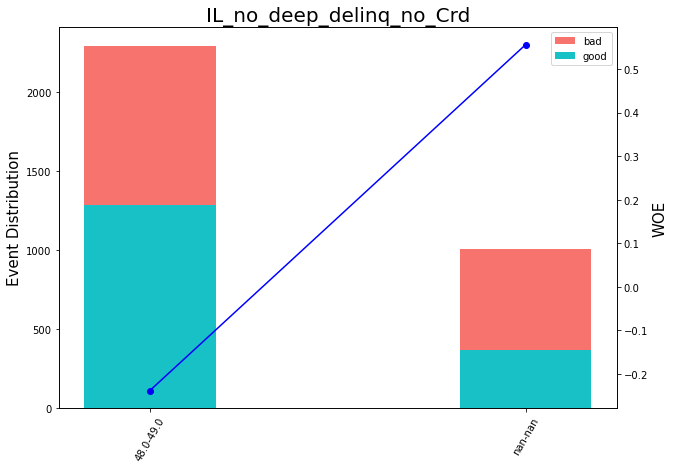

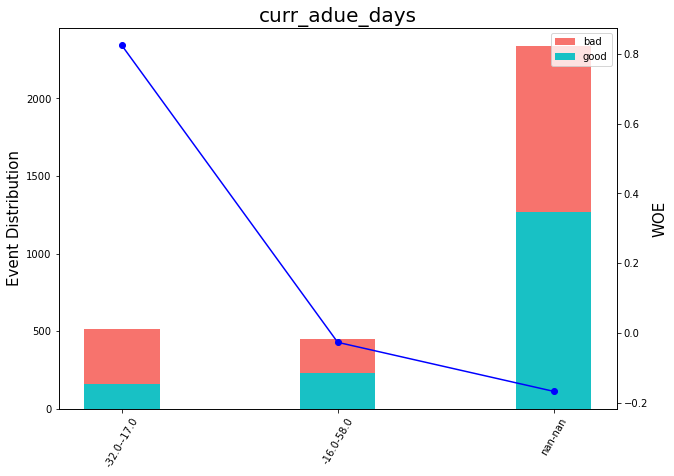

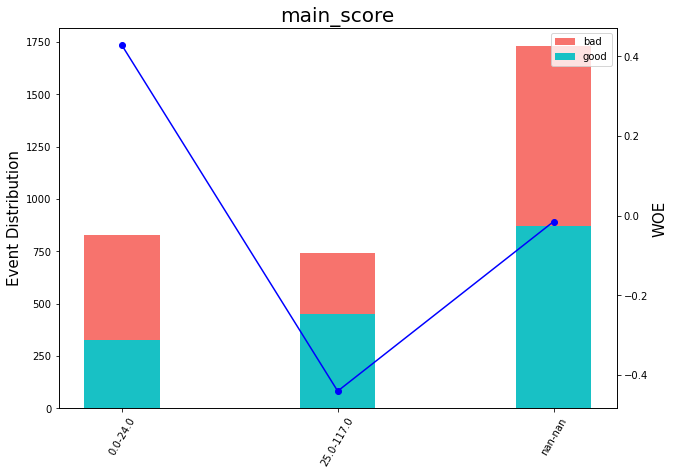

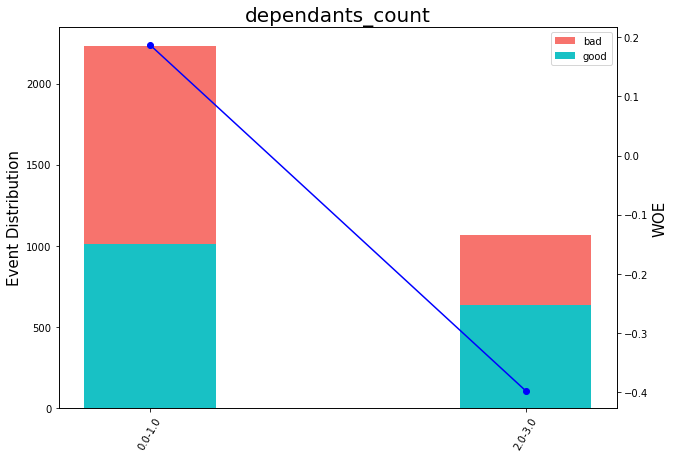

In [94]:
plot_all_bins(iv_df, X_train)

In [95]:
X_train.columns = 'WOE_' + X_train.columns
X_test.columns = 'WOE_' + X_test.columns
X_out.columns = 'WOE_' + X_out.columns

In [96]:
vars_current = ['WOE_max_expired_days',
              # 'WOE_open_date_cnt_360d',
               'WOE_sum_IL_credit_sum_no_Crd',
               'WOE_IL_no_deep_delinq_no_Crd',
               'WOE_curr_adue_days',
               'WOE_exp_days_last',
               'WOE_main_score',
               'WOE_dependants_count',
               'WOE_coll_days_max_older',
               'WOE_bor_age']

In [97]:
clf_lr = pickle.load(open("pickle/logreg.pkl", "rb"))

In [98]:
clf_lr.coef_


array([[0.29423841, 0.16449427, 0.09189101, 0.08628994, 0.24319133,
        0.06014184, 0.05175563, 0.09516866, 0.09593675]])

In [99]:
X_train.columns

Index(['WOE_max_expired_days', 'WOE_exp_days_last',
       'WOE_sum_IL_credit_sum_no_Crd', 'WOE_coll_days_max_older',
       'WOE_bor_age', 'WOE_IL_no_deep_delinq_no_Crd', 'WOE_curr_adue_days',
       'WOE_main_score', 'WOE_dependants_count'],
      dtype='object')

In [100]:
X_train = X_train[vars_current]
X_test = X_test[vars_current]
X_out = X_out[vars_current]

In [101]:
X_train_cpy = X_train.copy()
X_test_cpy = X_test.copy()
X_out_cpy = X_out.copy()

In [102]:
X_train = X_train_cpy.copy()
X_test = X_test_cpy.copy()
X_out = X_out_cpy.copy()

In [103]:
X = pd.concat([X_test, X_out])
y = pd.concat([y_test, y_out])

Selection Types:
'f' - forward
'b' - backward
'e' - exhaustive (computationally hard)
'ff' - forward floating
'bf' - backward floating
'kb' - K-Best based on performance
'RFE' - recursive feature elimination
'ALL' - Try All types (computatuionally expensive)

In [104]:
X_out = X_out[list(X_train.columns)]

In [105]:
# Score and PD

X['PD'] = clf_lr.predict_proba(X[list(X_train.columns)])[:,1] 
X['Score'] = 1000 - round(1000*(X['PD']))
X['y'] =y

In [106]:
X.shape

(1364, 12)

In [116]:
M_r = np.array([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])[::-1]
M_e = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])[::-1]
M_es = ['(0-50]', '(50-100]', '(100-150]', '(150-200]', '(200-250]', '(250-300]', '(300-350]',\
        '(350-400]', '(400-450]', '(450-500]', '(500-550]', '(550-600]', '(600-650]', '(650-700]',\
       '(700-750]', '(750-800]', '(800-850]', '(850-900]','(900-950]', '(950-1000]'][::-1]

In [117]:
M_e

array([1000,  950,  900,  850,  800,  750,  700,  650,  600,  550,  500,
        450,  400,  350,  300,  250,  200,  150,  100,   50])

In [118]:
All_1 = []
dAll_1 = []
Bad_1 = []
Good_1 = []
BR_1 = []


for x in M_e:
    All_1i  = X[((X['Score'] <= x) & (X['Score'] > (x-50)) ) ].shape[0]
    Bad_1i  = X[((X['Score'] <= x) & (X['Score'] > (x-50))  &    (X['y'] == 1))].shape[0]
    Good_1i = X[((X['Score'] <= x) & (X['Score'] > (x-50))  &    (X['y'] == 0))].shape[0]
    
    dAll_1i = All_1i/X.shape[0]
    try:
        BR_1i = Bad_1i/All_1i
    except:
        BR_1i = 0
        
  
#---------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------

    All_1.append(All_1i)
    dAll_1.append(dAll_1i)
    Bad_1.append(Bad_1i)
    Good_1.append(Good_1i)
    BR_1.append(BR_1i)
    
T_str = pd.DataFrame(M_es, columns = ['Score'])
T_str['All'] = All_1
T_str['dAll'] = dAll_1
T_str['Bad'] = Bad_1
T_str['Good'] = Good_1
T_str['BR'] = BR_1


In [119]:
T_str

,Score,All,dAll,Bad,Good,BR
0,(950-1000],0,0.000000,0,0,0.000000
1,(900-950],0,0.000000,0,0,0.000000
2,(850-900],0,0.000000,0,0,0.000000
3,(800-850],0,0.000000,0,0,0.000000
4,(750-800],0,0.000000,0,0,0.000000
5,(700-750],0,0.000000,0,0,0.000000
6,(650-700],1,0.000733,0,1,0.000000
7,(600-650],144,0.105572,1,143,0.006944
8,(550-600],599,0.439150,5,594,0.008347
9,(500-550],248,0.181818,12,236,0.048387


In [120]:
T_str.to_excel('Scorebt.xlsx')

In [200]:
df3 = coef_woe_columns(df3, feat)
df3['requested_month_year'] = df3.date_requested.map(lambda x: str(x)[:7])

In [201]:
# Score buckets
df3['Score_bucket'] = df3.Score.map(lambda x: str(int((x//100)*100))+'-'+ str(int((x//100)+1)*100))
#df3.date_requested = df3.date_requested.map(lambda x: datetime.date(x))
df3['requested_month_year'] = df3.date_requested.map(lambda x: str(x)[:7])

# Pivot table of Score Buckets
table = pd.pivot_table(
    df3,
    index=['requested_month_year'],
    columns=['Score_bucket'],
    values=['Score'],
    aggfunc='count').fillna(0)

In [202]:
Ginis = create_gini_stability(df3, clf_lr, X_train)
Ginis

,Gini,Goods,Bads
Months,,,
2020-07,0.491,497,465
2020-08,0.636,572,368
2020-09,0.652,532,723
2020-10,0.617,636,754
2020-11,0.455,603,528
2020-12,0.539,282,284


In [203]:
DSL = generate_DSL(ivs, feat)
SQL = generate_SQL(ivs, feat)

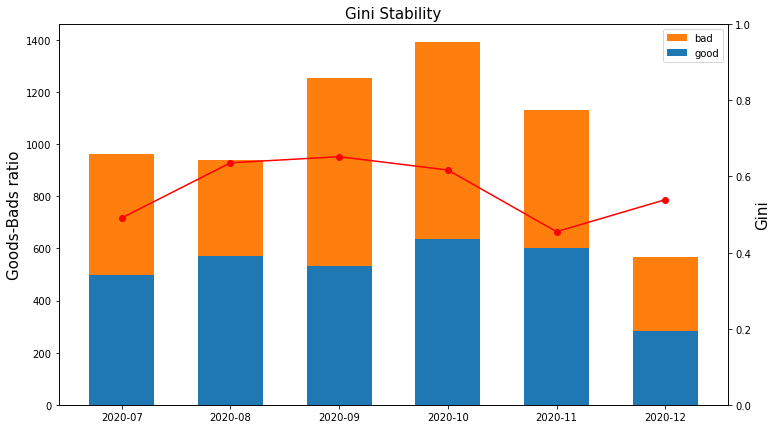

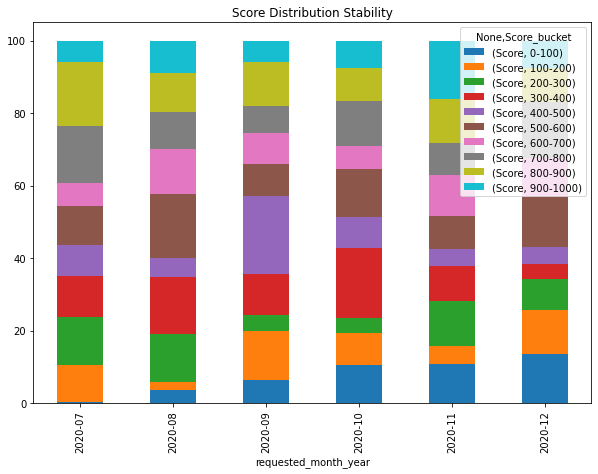

In [204]:
gini_stability_chart(Ginis)
score_stability_graph(table)

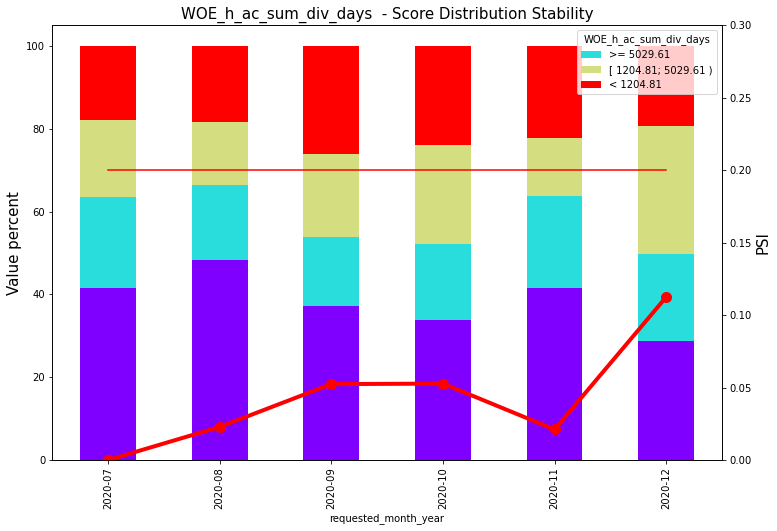

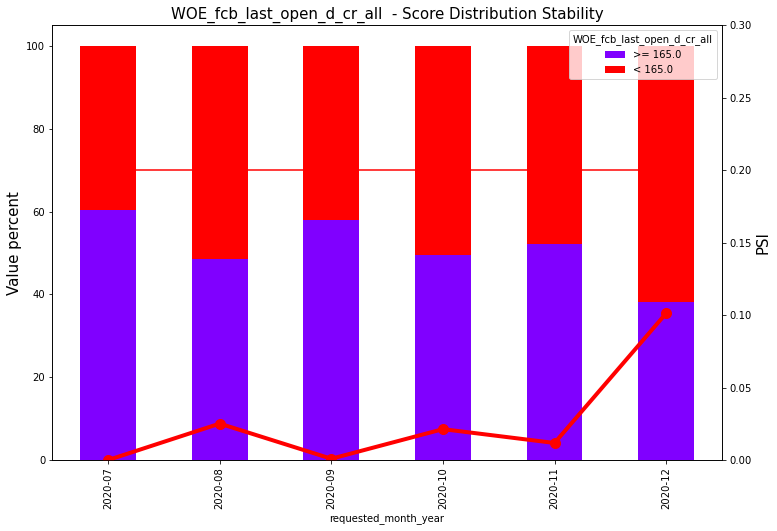

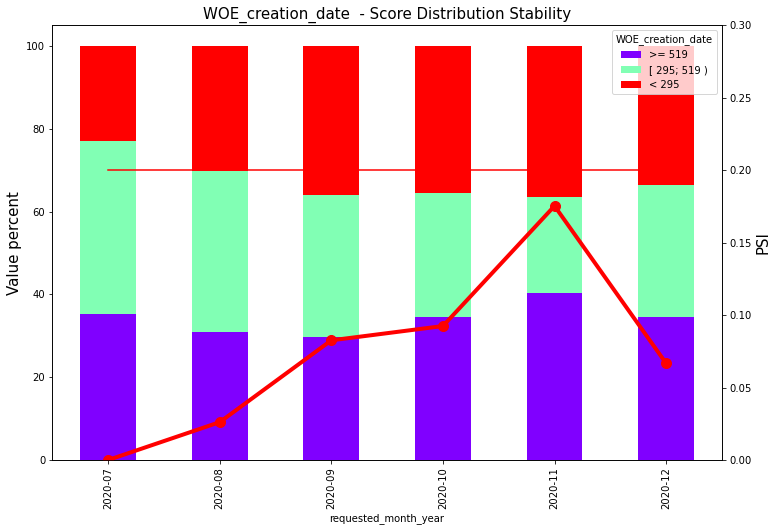

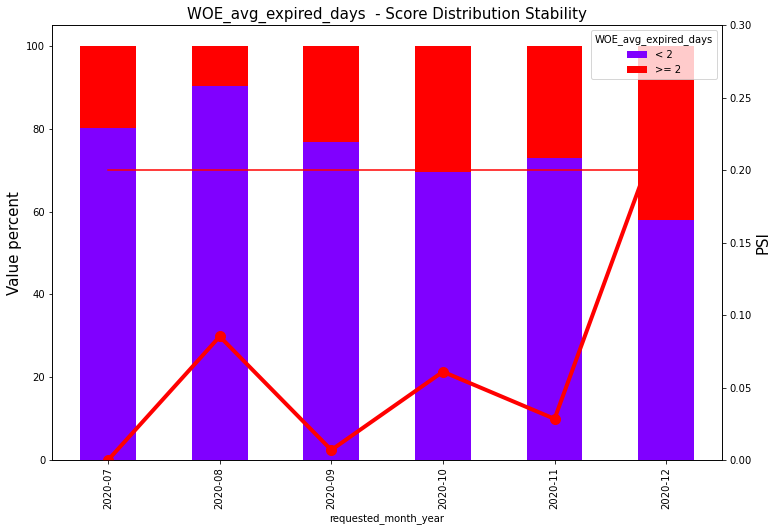

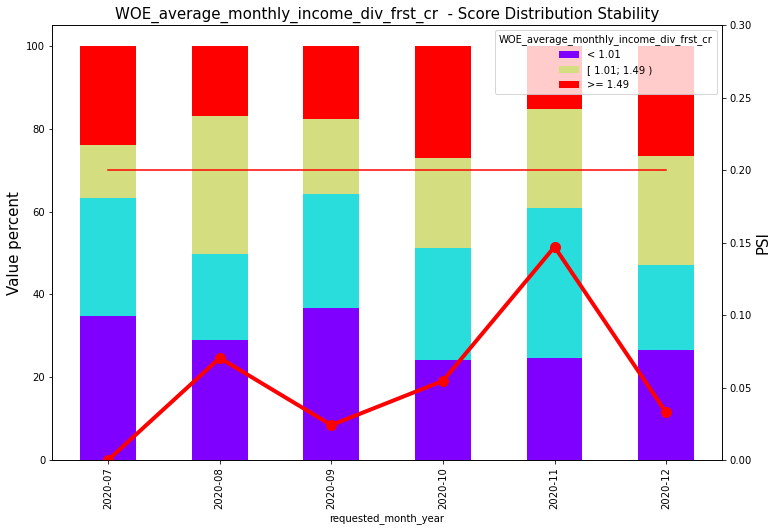

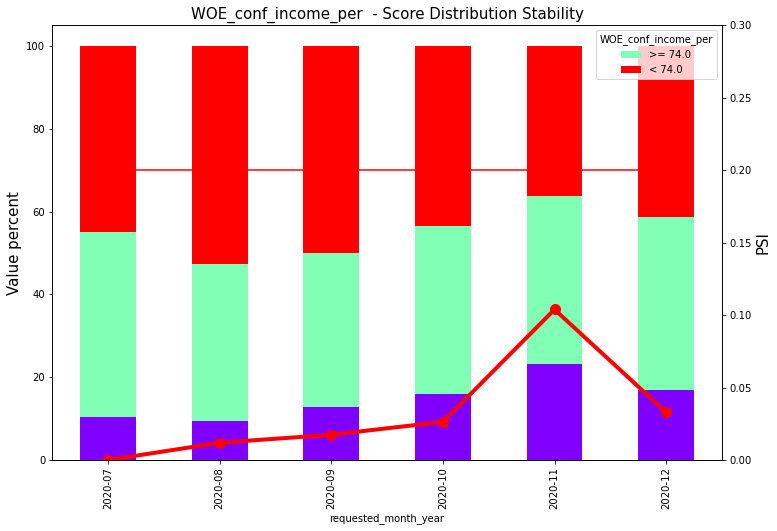

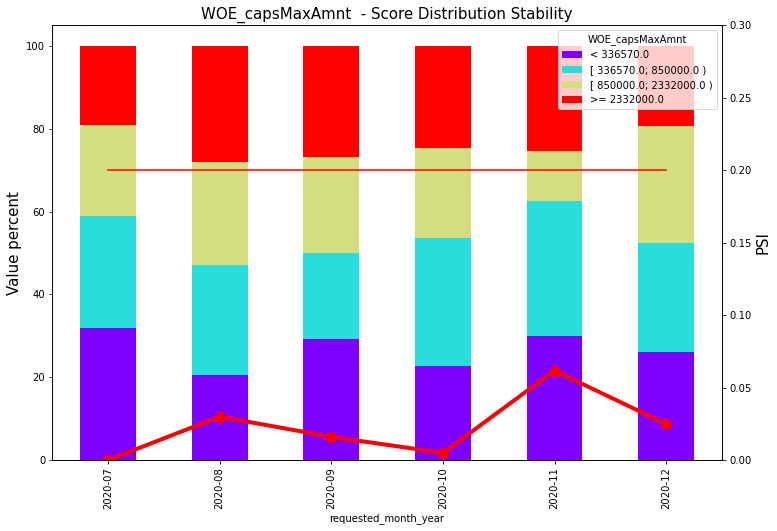

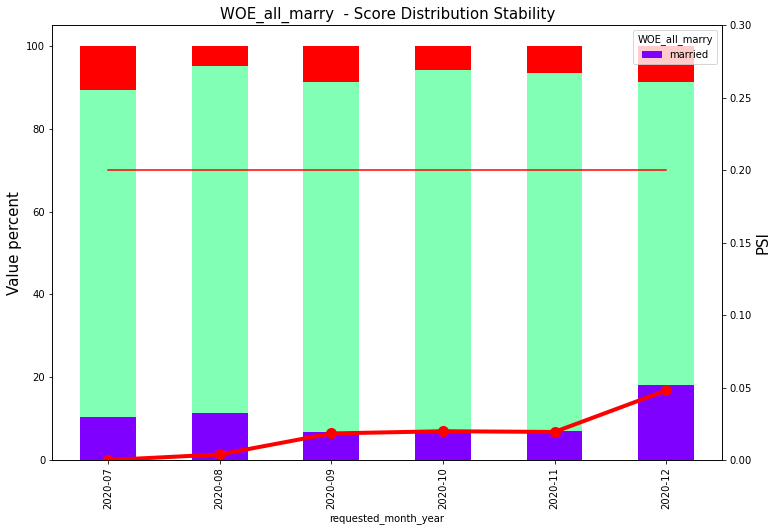

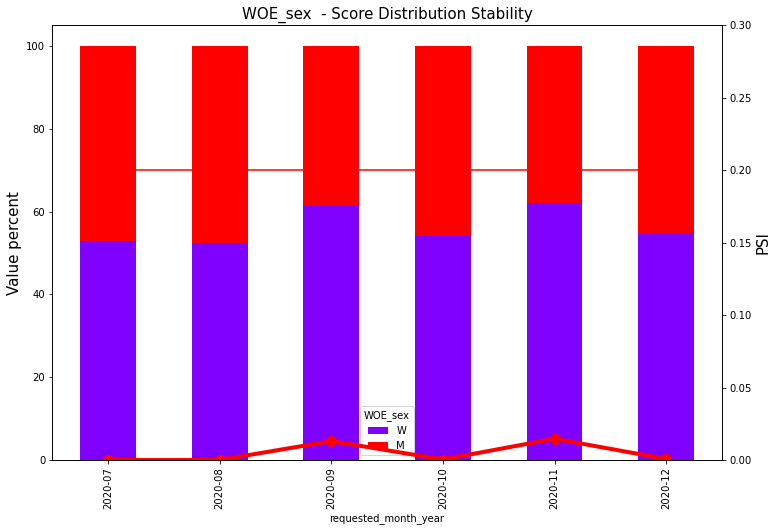

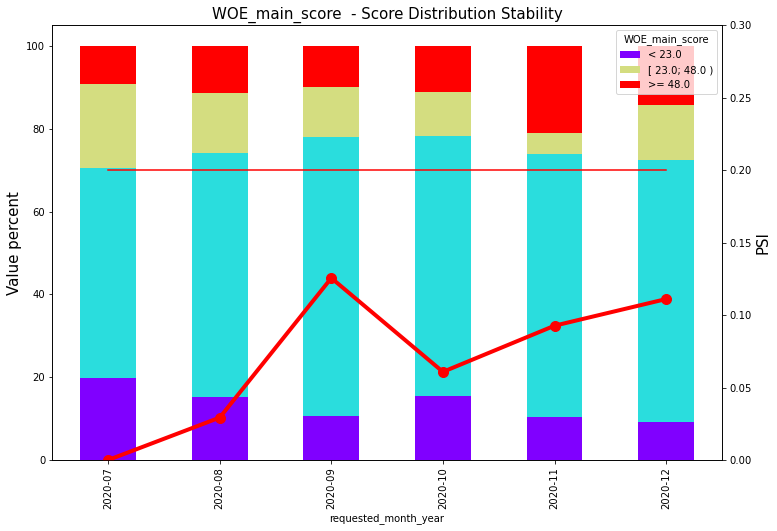

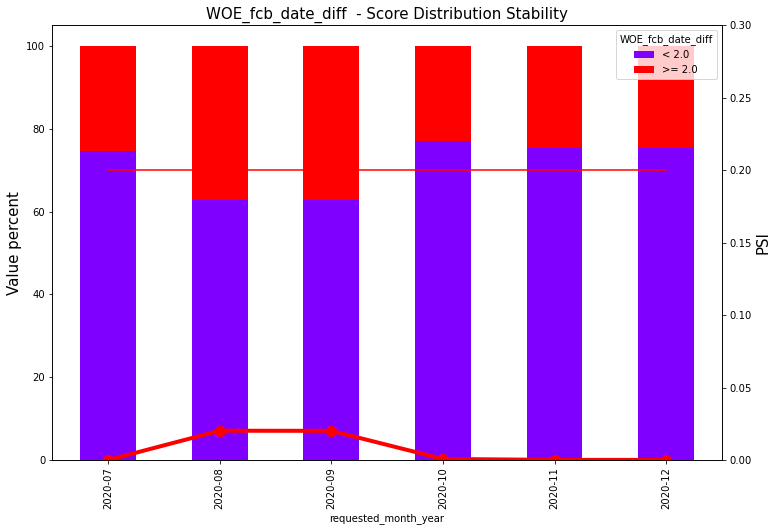

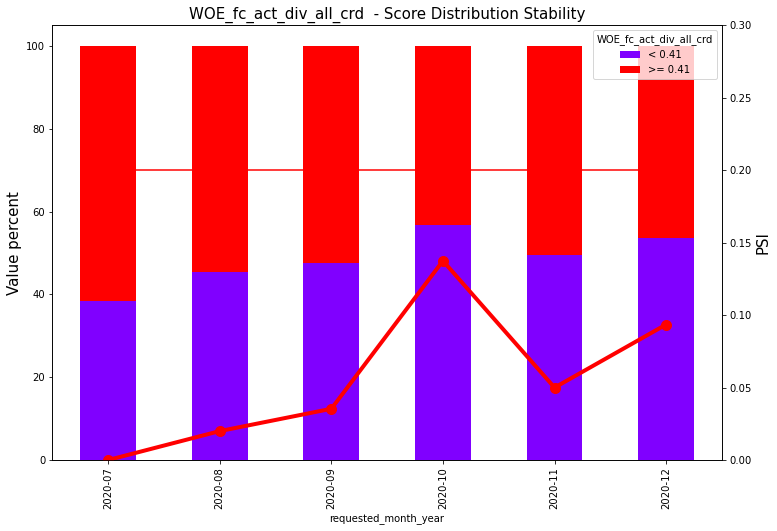

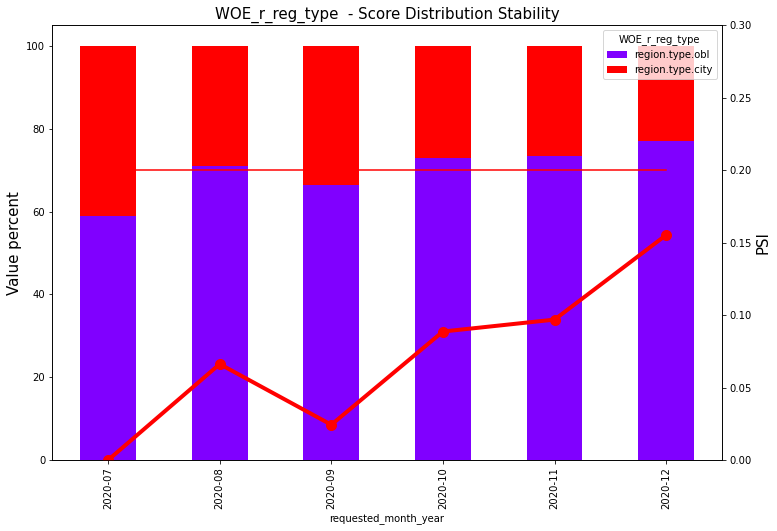

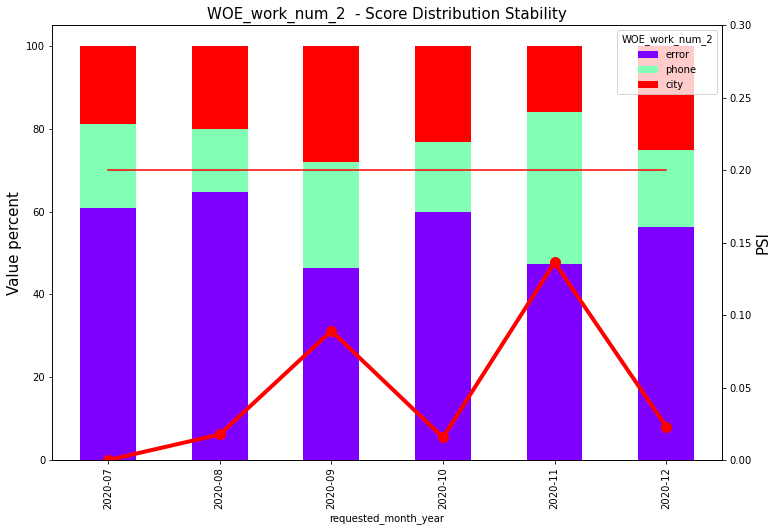

In [205]:
features_of_model = population_stability(df3, ivs, feat)

In [206]:
save_all('slkz1.0_score', X_train, X_test, clf_lr, iv_df, IV, iv_df, df3, else_df, _)

Saving X_train...
Saving X_test...
Saving clf_lr...
Saving iv_df_RI...
Saving IV...
Saving iv_df...
Saving df3...
Saving else_df...
Saving cols_to_drop...
All Data Saved!


# Reject inference preparation

In [207]:
X_train, X_test, clf_lr, iv_df_RI, IV, iv_df, df3, else_df, _ = load_all('slkz1.0_score')

Loading X_train...
Loading X_test...
Loading clf_lr...
Loading iv_df_RI...
Loading IV...
Loading iv_df...
Loading df3...
Loading else_df...
Loading cols_to_drop...
All Data Loaded!


In [208]:
df3.shape

(6244, 50)

In [209]:
name_2 = 'slkz1.0_score_' + (str(time.time())) 

In [210]:
export_to_excel(DSL, SQL, X_train, X_test, y_train, y_test, y, df3, iv_df, ivs, Ginis, table, scores, feat, features_of_model, clf_lr, 
                    name= name_2)

Exported!


In [211]:
#WRITING
writer = pd.ExcelWriter('slkz1.0_score_.xlsx', engine='xlsxwriter')

workbook  = writer.book
worksheet = workbook.add_worksheet('Sample information')
bold = workbook.add_format({'bold': True})
percent_fmt = workbook.add_format({'num_format': '0.00%'})

worksheet.set_column('A:A', 20)
worksheet.set_column('B:B', 15)
worksheet.set_column('C:C', 10)

# Sample
worksheet.write('A2', 'Sample conditions', bold)
worksheet.write('A3', 1)
worksheet.write('A4', 2)
worksheet.write('A5', 3)
worksheet.write('A6', 4)

# Model
worksheet.write('A8', 'Model development', bold)

worksheet.write('A9', 1)
#labels
worksheet.write('C8', 'Bads')
worksheet.write('D8', 'Goods')
worksheet.write('B9', 'Train')
worksheet.write('B10', 'Valid')
worksheet.write('B11', 'Total')

# goods and bads
worksheet.write('C9', y_train.value_counts()[1])
worksheet.write('C10', y_test.value_counts()[1])
worksheet.write('D9', y_train.value_counts()[0])
worksheet.write('D10', y_test.value_counts()[0])
worksheet.write('C11', y.value_counts()[1])
worksheet.write('D11', y.value_counts()[0])

# NPL
worksheet.write('A13', 2)
worksheet.write('B13', 'NPL')
worksheet.write('C13', (y.value_counts()[1]/(y.value_counts()[1]+y.value_counts()[0])), percent_fmt)

worksheet.write('A16', 3)
worksheet.write('C15', 'Gini')
worksheet.write('B16', 'Train')
worksheet.write('B17', 'Valid')
worksheet.write('B18', 'CV Scores')
worksheet.write('C18', str([round(sc, 2) for sc in scores]))

worksheet.write('C16', round(2*roc_auc_score(y_train, clf_lr.predict_proba(X_train)[:,1]) - 1, 3))
worksheet.write('C17', round(2*roc_auc_score(y_test, clf_lr.predict_proba(X_test)[:,1]) - 1, 3))

# Regreesion coefs
feat.to_excel(writer, sheet_name='Regression coefficients', index=False)
worksheet2 = writer.sheets['Regression coefficients']
worksheet2.set_column('A:A', 15)
worksheet2.set_column('B:B', 50)

#WOE

ivs[['VAR_NAME', 'Variable range', 'WOE', 'COUNT', 'WOE_group']].to_excel(writer, sheet_name='WOE', index=False)
worksheet3 = writer.sheets['WOE']
worksheet3.set_column('A:A', 50)
worksheet3.set_column('B:B', 60)
worksheet3.set_column('C:C', 30)
worksheet3.set_column('D:D', 20)
worksheet3.set_column('E:E', 12)
for num, i in enumerate([x.replace('WOE_','') for x in X_train.columns]):
        ev = iv_df[iv_df.VAR_NAME==i]
        ev.reset_index(inplace=True)
        worksheet3.insert_image('G{}'.format(num*34+1), '{}.png'.format(i))

df3.to_excel(writer, sheet_name='Data', index=False)

table.to_excel(writer, sheet_name='Scores by buckets', header = True, index = True)
worksheet4 = writer.sheets['Scores by buckets']
worksheet4.set_column('A:A', 20)
worksheet4.insert_image('J1', 'score_distribution.png')
Ginis.to_excel(writer, sheet_name='Gini distribution', header = True, index = True)
worksheet5 = writer.sheets['Gini distribution']
worksheet5.insert_image('E1', 'gini_stability.png')
worksheet6 = workbook.add_worksheet('Variables Stability')

for num, i in enumerate(features_of_model): 
    worksheet6.insert_image('A{}'.format(num*34+1), 'Stability_of_{}.png'.format(i))

worksheet7 = workbook.add_worksheet('DSL')
worksheet7.set_column('A:A', 270)
worksheet7.write('A1', DSL)
writer.save()

In [212]:
from sklearn import grid_search
parameters = {
            'penalty':['l2'],
            'C':[0.01, 0.1, 1, 10,100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
        }
GS = grid_search.GridSearchCV(lg, parameters,cv=10,verbose=10)
GS.fit(x,y)
print(GS.best_params_) # output: {'penalty': 'l2', 'C': 100, 'solver': 'liblinear'}
print(GS.best_score_) # output: 0.98

ImportError: cannot import name 'grid_search' from 'sklearn' (C:\Users\Petr\anaconda3\lib\site-packages\sklearn\__init__.py)